In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Text(0.5, 1.0, 'Class Imbalance')

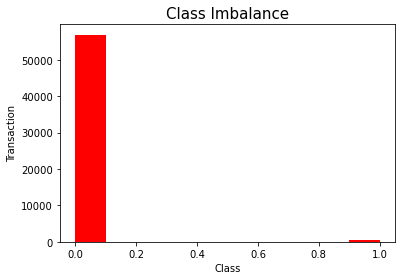

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel('./CreditCardDataset.xlsx')
plt.hist(data['Class'], color='red')
plt.xlabel('Class')
plt.ylabel('Transaction')
plt.title('Class Imbalance', fontsize=15)

In [7]:
pc_fraud = len(data.loc[data['Class'] == 1].values)/len(data.loc[data['Class'] == 0].values)
print(pc_fraud*100)
print(data.head())

0.8652375006594798
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
1     2 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
2     7 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
3    11  1.069374  0.287722  0.828613  2.712520 -0.178398  0.337544 -0.096717   
4    12 -0.752417  0.345485  2.057323 -1.468643 -1.158394 -0.077850 -0.608581   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   
1  0.260314 -0.568671  ... -0.208254 -0.559825 -0.026398 -0.371427 -0.232794   
2 -3.807864  0.615375  ...  1.943465 -1.015455  0.057504 -0.649709 -0.415267   
3  0.115982 -0.221083  ... -0.036876  0.074412 -0.071407  0.104744  0.548265   
4  0.003603 -0.436167  ...  0.499625  1.353650 -0.256573 -0.065084 -0.039124   

        V26  

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# Original dataset
x = data.drop('Class', axis=1).values
y = data['Class'].values
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

print('Sampled train dataset shape %s' % Counter(ytrain))
print('Sampled validation dataset shape %s' % Counter(ytest))

Sampled train dataset shape Counter({0: 45494, 1: 390})
Sampled validation dataset shape Counter({0: 11369, 1: 102})


In [9]:
import torch

bs =100

#creating torch dataset and loader using original dataset. 
#to use resampled dataset, replace ex. xtrain with xtrain_over etc.
train_ds = torch.utils.data.TensorDataset(torch.tensor(xtrain).float(), torch.tensor(ytrain).float())
valid_ds = torch.utils.data.TensorDataset(torch.tensor(xtest).float(), torch.tensor(ytest).float())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs)

In [10]:
#network class 2-hidden layer model
class Classifier(torch.nn.Module):
    def __init__(self, n_input=10, n_hidden = 20, n_output = 1,drop_prob=0.5):
        super().__init__()
        self.extractor1 = torch.nn.Linear(n_input, n_hidden)
        self.extractor2 = torch.nn.Linear(n_hidden, n_hidden)
        self.relu = torch.nn.ReLU()
        self.drop_out = torch.nn.Dropout(drop_prob)
        self.classifier = torch.nn.Linear(n_hidden, n_output)

    def forward(self, xb):
        x = self.relu(self.extractor1(xb))
        x = self.relu(self.extractor2(x))
        x = self.drop_out(x)
        return self.classifier(x).squeeze()


In [11]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [12]:
#training the network
def train(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)


In [13]:
#network setting
n_input = xtrain.shape[1]
n_output = 1
n_hidden = 15

model = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

lr = 0.001

#for orignal dataset, I use pos_weight.
pos_weight = torch.tensor([5])
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

n_epoch = 200

In [14]:
train(n_epoch,model,loss_func,opt,train_dl,valid_dl)
model.eval()


0 0.17838875182955696
1 0.17533111928069656
2 0.17393570196975672
3 0.1723621333682561
4 0.1707591269025307
5 0.16901126167365993
6 0.16714118185563778
7 0.16477691892753055
8 0.1620311825524419
9 0.15876380393981268
10 0.15452139897829112
11 0.14975181849522864
12 0.14378194807764855
13 0.13795212733486809
14 0.13242978925391527
15 0.12665124726621788
16 0.12064399774628876
17 0.11482699106618464
18 0.1094963927500365
19 0.10481525053135468
20 0.10043094043221534
21 0.09626637493895836
22 0.09224341560011286
23 0.08835618347631026
24 0.08486513152657489
25 0.0814784017691335
26 0.07782684890620742
27 0.07463333121578121
28 0.07159899954097323
29 0.06865467736290488
30 0.06624703105172433
31 0.06414055478981649
32 0.062082502514217444
33 0.06021932286620608
34 0.05875488400339779
35 0.05794708622844729
36 0.05630042552431634
37 0.05545735683965372
38 0.054621699015504295
39 0.05334979446775183
40 0.05217621653733632
41 0.052301255689753495
42 0.05104742620295223
43 0.05118081212135019


KeyboardInterrupt: 

In [ ]:
from sklearn import metrics
ypred = model(torch.tensor(xtest).float()).detach().numpy()

ypred [ypred>=0.5] =1.0
ypred [ypred<0.5] =0.0
print('Confusion matrix: {}'. format(metrics.confusion_matrix(ytest, ypred)))
print('AUPRC score: {}'. format(metrics.average_precision_score(ytest, ypred)))
print('AUROC score: {}'.format(metrics.roc_auc_score(ytest, ypred)))
print('Accuracy score: {}'.format(metrics.accuracy_score(ytest, ypred)))
print(metrics.classification_report(ytest, ypred))